<a href="https://colab.research.google.com/github/GauravB7/AdmissionPrediction/blob/master/Admission_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Setting up Java Environment to Java 8 from Default Java 11
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
!tar xf spark-2.4.1-bin-hadoop2.7.tgz
!pip install -q findspark

tar: spark-2.4.1-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
#Installing the Pyspark library
!pip install pyspark==2.4.5

     |████████████████████████████████| 217.8MB 56kB/s 
     |████████████████████████████████| 204kB 32.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=02ac0f137138efecde18dc449d262007ae1f1d9def2303190dbabaff93ab3c32
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [4]:
#Checking whether pyspark installed properly or not and importing necessary packages out of it
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [5]:
#Creating an Spark instance
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [6]:
import pandas             #importing pandas library to read csv file and create dataframe out of it
df=pandas.read_csv('https://raw.githubusercontent.com/GauravB7/AdmissionPrediction/master/datasets_14872_228180_Admission_Predict.csv')
df=spark.createDataFrame(df)  #Converting pandas dataframe to spark dataframe

In [7]:
df.createOrReplaceTempView("df")  #Creating a Table view of the DataFrame
spark.sql("SELECT * from df").show()  #A look at the data 

+---------+--------+----------+-----------------+---+---+----+--------+-------------+
|SerialNo.|GREScore|TOEFLScore|University_Rating|SOP|LOR|CGPA|Research|ChanceofAdmit|
+---------+--------+----------+-----------------+---+---+----+--------+-------------+
|        1|     337|       118|                4|4.5|4.5|9.65|       1|         0.92|
|        2|     324|       107|                4|4.0|4.5|8.87|       1|         0.76|
|        3|     316|       104|                3|3.0|3.5| 8.0|       1|         0.72|
|        4|     322|       110|                3|3.5|2.5|8.67|       1|          0.8|
|        5|     314|       103|                2|2.0|3.0|8.21|       0|         0.65|
|        6|     330|       115|                5|4.5|3.0|9.34|       1|          0.9|
|        7|     321|       109|                3|3.0|4.0| 8.2|       1|         0.75|
|        8|     308|       101|                2|3.0|4.0| 7.9|       0|         0.68|
|        9|     302|       102|                1|2.0|1

In [8]:

df.columns

['SerialNo.',
 'GREScore',
 'TOEFLScore',
 'University_Rating',
 'SOP',
 'LOR',
 'CGPA',
 'Research',
 'ChanceofAdmit']

In [9]:
import numpy as np

means=spark.sql("select mean(GREScore),mean(TOEFLScore),mean(University_Rating),mean(LOR),mean(CGPA),mean(Research) from df").collect() #Calculating mean values of Open,High,Low and Close Columns
means=np.array(means)
means

array([[316.8075  , 107.41    ,   3.0875  ,   3.4525  ,   8.598925,
          0.5475  ]])

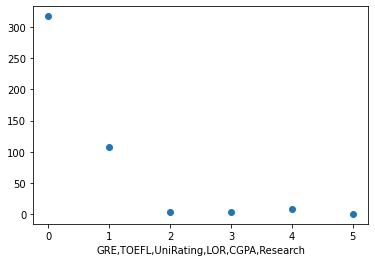

In [10]:
#Plotting the means using Scatter Plots
%matplotlib inline
import matplotlib.pyplot as plt

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter([0,1,2,3,4,5],means)
ax.set_xlabel('GRE,TOEFL,UniRating,LOR,CGPA,Research')
plt.show()

In [11]:
sds = spark.sql("select stddev(GREScore),stddev(TOEFLScore),stddev(University_Rating),stddev(LOR),stddev(CGPA),stddev(Research) from df").collect()
sds

[Row(stddev_samp(CAST(GREScore AS DOUBLE))=11.473646113500477, stddev_samp(CAST(TOEFLScore AS DOUBLE))=6.069513777374129, stddev_samp(CAST(University_Rating AS DOUBLE))=1.1437281298838982, stddev_samp(LOR)=0.8984775482792572, stddev_samp(CGPA)=0.596317096496432, stddev_samp(CAST(Research AS DOUBLE))=0.49836197853983133)]

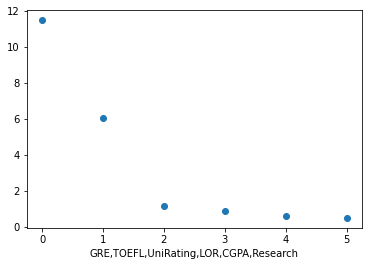

In [12]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter([0,1,2,3,4,5],sds)
ax.set_xlabel('GRE,TOEFL,UniRating,LOR,CGPA,Research')
plt.show()

In [13]:
data=df.randomSplit([0.8,0.2])
train_data=data[0]
test_data=data[1]


train_data.createOrReplaceTempView("train_data")  #Creating a Table view of the DataFrame
test_data.createOrReplaceTempView("test_data")  #Creating a Table view of the DataFrame 

x_train=spark.sql("select GREScore,TOEFLScore,University_Rating, LOR,CGPA,Research from train_data ").collect()

x_test=spark.sql("select GREScore,TOEFLScore,University_Rating, LOR,CGPA,Research from test_data ").collect()


In [14]:
y_train=spark.sql("select ChanceofAdmit from train_data ").collect()

y_test=spark.sql("select ChanceofAdmit from test_data ").collect()



In [15]:
#importing SVR from sklearn
from sklearn.svm import SVR
svr= SVR(C=800,max_iter=160,gamma=0.049,kernel='rbf',epsilon=0.049) #Creating an instance to the Support Vector Regressor

In [16]:
model=svr.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=160).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [17]:
eval1=model.score(x_test,y_test)  #Evaluate the SVR with testing dataset
print(eval1)

0.6072471542265299


In [18]:
eval2=model.predict(x_test)  #Evaluate the SVR with testing dataset
print(eval2)

  

[0.75954295 0.57805481 0.83935781 0.76754658 0.7219029  0.84614113
 0.56371895 0.50715176 0.77854324 0.54596128 0.54516786 0.50416141
 0.68731931 0.89413212 0.4940261  0.78516916 0.78326103 0.44710919
 0.50287342 0.82855083 0.8687216  0.47040531 0.89554323 0.62850958
 0.74057734 0.50022333 0.67893858 0.40581968 0.76254458 0.80264157
 0.80838871 0.66973726 0.74502142 0.83071344 0.82105739 0.85904814
 0.7410925  0.64134555 0.67280325 0.45645566 0.78998231 0.89924315
 0.56700328 0.82450541 0.69063421 0.89287798 0.88962592 0.69121039
 0.66538021 0.94255469 0.81836667 0.6553235  0.71835051 0.73766444
 0.54215792 0.76071696 0.75411784 0.83871912 0.8439836  0.6664047
 0.52061779 0.57847908 0.84883195 0.92062917 0.49355381 0.60988836
 0.61586196 0.78727409 0.61497013 0.41721156 0.79911873 0.76785635
 0.88842602 0.83377372 0.91211539 0.6066593  0.59041937 0.92690245
 0.42966136 0.85432571 0.66277782 0.81174357]


In [19]:
# Import pickle Package

import pickle

In [20]:
Pkl_Filename = "Pickle_RG_Model1.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [21]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    model = pickle.load(file)
model

SVR(C=800, cache_size=200, coef0=0.0, degree=3, epsilon=0.049, gamma=0.049,
    kernel='rbf', max_iter=160, shrinking=True, tol=0.001, verbose=False)

In [22]:
pred_array=np.array([[338,117,4,4.5,9.65,0]])
pred=model.predict(pred_array)
pred
#pred_array.shape

array([0.91278704])